# 1. CIFAR-10 CNN - The Importance of Dropout

CIFAR-10 is a commonly used dataset for training deep learning algorithms. It is often used in machine learning research, in part because the low-resolution images allow for algorithms to quickly process the data. In the first part of my analysis, I will be examining the intuition and importance of including Dropout in my neural network architecture. This short work is geared toward those with a foundation in basic deep learning concepts, and so explanations about the other aspects of my architecture, including optimizers, batch normalization, convolution, and max pooling are considered out of scope.

This dataset includes 50,000 training images and 10,000 test images that belong to one of 10 possible classes: Airplanes, Cars, Birds, Cats, Deer, Dogs, Frogs, Horses, Ships, and Trucks. Each entry is a 32-pixel x 32-pixel RGB-colored image.

I first plot a subset of the CIFAR-10 dataset to offer some visual intuition about the data. I use an adaptation of this [sample code](https://machinelearningmastery.com/how-to-load-and-visualize-standard-computer-vision-datasets-with-keras/) to load and visualize an image from each of the first 9 categories, which helps to put the data into better context. It's clear that the images are pretty blurry, so even a human could feasibly struggle with some of these.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

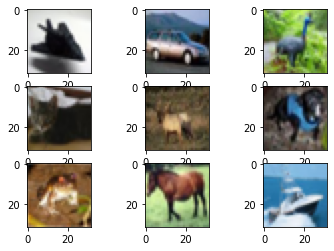

In [11]:
from tensorflow.keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = keras.datasets.cifar10.load_data()
indices = []
for i in range(9):
  indices.append(np.where(label_train==i)[0][0])

for j, k in enumerate(indices):
  plt.subplot(330+1+j)
  plt.imshow(data_train[k])
plt.show()


Next, I scale the features to range from 0 to 1, a standard step in deep learning pre-processing. I also reshape the labels so that they are one-hot encoded for use with Keras' Categorical Cross Entropy loss, the preferred loss function for multi-class classification problems.

In [12]:
data_train, data_test = (data_train/255.).astype('float32'), (data_test/255.).astype('float32')
label_train = keras.utils.to_categorical(label_train, 10, dtype='float32')
label_test = keras.utils.to_categorical(label_test, 10, dtype='float32')

In [13]:
print(data_train.shape)
print(label_train.shape)

(50000, 32, 32, 3)
(50000, 10)


Because the purpose of this part of the analysis is to better understand the purpose of Dropout in a neural network rather than to achieve maximal performance, I set some sensible hyperparameters for use with both models. 

In [14]:
#Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 100
n_batches = 50 #To save computational time, I use only the first 50 batches for training in a given epoch

### First Model - No Dropout
This is a simple CNN architecture with three convolutional layers consisting of 5x5 receptive fields, each followed by 2x2 max pooling layers with stride 2. There is one fully-connected layer at the end with ReLU activation, which is finally followed by a dense layer with Softmax activation that classifies each image into one of the ten possible classes.

In [15]:
#Conv NN without dropout
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)             

### Second Model - Dropout
The second model is identical to the first, except that after each Max Pooling layer, I include a 30% dropout layer. The purpose of a Dropout layer is to introduce model regularization that can prevent overfitting to the training data. Here, for every dropout layer, 30% of the neurons *and all of their connections* are dropped during the training process. Because this happens differently for each mini-batch, there is an added benefit of allowing the model to experiment with countless different subnetworks, each with a different missing set of neurons. As a result, we reap some of the benefits of ensemble training (where we would average the outputs of many separately trained models) for a fraction of the computational cost.

In [16]:
#Conv NN with Dropout layers, each with rate of 0.3 
model_drop = keras.Sequential()
model_drop.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(32,32,3)))
model_drop.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model_drop.add(keras.layers.Dropout(0.3))
model_drop.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_drop.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model_drop.add(keras.layers.Dropout(0.3))
model_drop.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_drop.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model_drop.add(keras.layers.Dropout(0.3))
model_drop.add(keras.layers.Flatten())
model_drop.add(keras.layers.Dense(1000, activation='relu'))
model_drop.add(keras.layers.Dense(10, activation='softmax'))

model_drop.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

In [17]:
#Train models (with and without dropout)
def train_CNN(model):
  opt = keras.optimizers.Adam(learning_rate)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  print('\nTraining model...')
  history = model.fit(data_train, label_train, batch_size=batch_size, epochs=epochs, shuffle=True, steps_per_epoch=n_batches,\
            validation_data = (data_test, label_test), verbose=1)
  return history

history = list(map(train_CNN, [model, model_drop]))


Training model...
Epoch 1/100
50/50 [==============================] - 3s 21ms/step - loss: 2.1792 - accuracy: 0.1802 - val_loss: 1.7839 - val_accuracy: 0.3405
Epoch 2/100
50/50 [==============================] - 1s 15ms/step - loss: 1.7547 - accuracy: 0.3458 - val_loss: 1.6394 - val_accuracy: 0.3859
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 1.5791 - accuracy: 0.4182 - val_loss: 1.5208 - val_accuracy: 0.4353
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 1.5153 - accuracy: 0.4494 - val_loss: 1.3968 - val_accuracy: 0.4888
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 1.3777 - accuracy: 0.5013 - val_loss: 1.3342 - val_accuracy: 0.5159
Epoch 6/100
50/50 [==============================] - 1s 15ms/step - loss: 1.3234 - accuracy: 0.5131 - val_loss: 1.2632 - val_accuracy: 0.5463
Epoch 7/100
50/50 [==============================] - 1s 15ms/step - loss: 1.2845 - accuracy: 0.5431 - val_loss: 1.1928 - val_accu

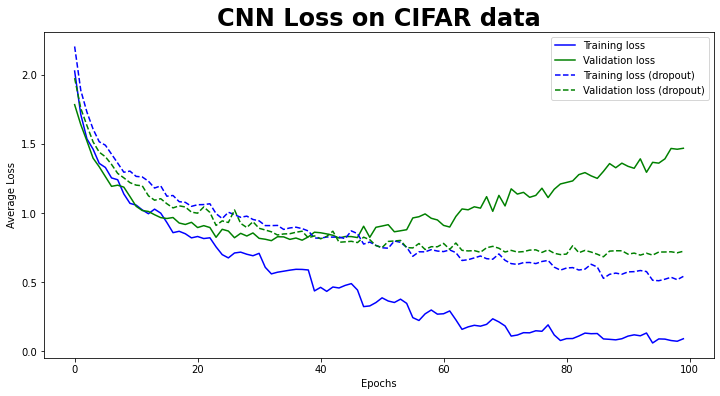

In [18]:
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(history[0].history['loss'], color='blue', label='Training loss')
axes.plot(history[0].history['val_loss'], color='green', label='Validation loss')
axes.plot(history[1].history['loss'], color='blue', linestyle='dashed', label='Training loss (dropout)')
axes.plot(history[1].history['val_loss'], color='green', linestyle='dashed', label='Validation loss (dropout)')
axes.set_xlabel('Epochs')
axes.set_ylabel('Average Loss')
axes.set_title('CNN Loss on CIFAR data', fontsize=24, fontweight='bold')
axes.legend()

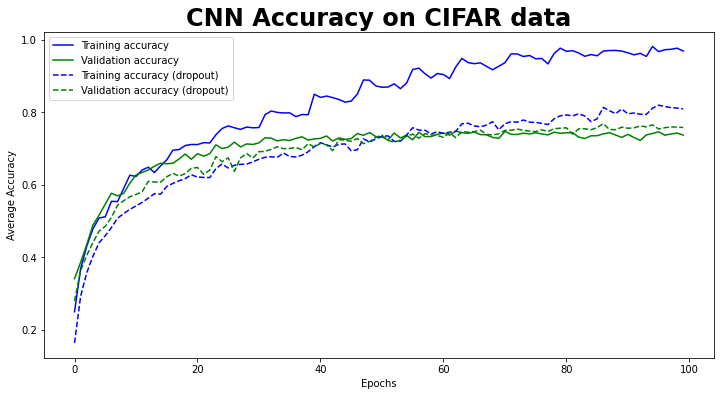

In [19]:
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(history[0].history['accuracy'], color='blue', label='Training accuracy')
axes.plot(history[0].history['val_accuracy'], color='green', label='Validation accuracy')
axes.plot(history[1].history['accuracy'], color='blue', linestyle='dashed', label='Training accuracy (dropout)')
axes.plot(history[1].history['val_accuracy'], color='green', linestyle='dashed', label='Validation accuracy (dropout)')
axes.set_xlabel('Epochs')
axes.set_ylabel('Average Accuracy')
axes.set_title('CNN Accuracy on CIFAR data', fontsize=24, fontweight='bold')
axes.legend()

## Discussion
Using the specific hyperparameters specified above, I achieve decent performance of about 74% validation accuracy with no dropout and 76% accuracy with dropout. Looking at the loss curves, what is most noteworthy is the U-shape of the validation loss for the no-dropout model. It is clear that after about 40 epochs, the model begins to overfit to the training data as the training loss continues to decrease, but the validation loss starts to rise. Including dropout to regularize the model remedies this overfitting issue, and we can see that the dropout validation loss is mostly decreasing over all 100 epochs.

Overall, the Dropout layers are functioning exactly as they should be, preventing overfitting of the CNN to the training set of images and slightly improving overall performance relative to the baseline model. While dropout certainly helps here, a better network architecture would lead to far more pronounced improvements. I will discuss this in more detail in #2 below.

# 2. CIFAR-10 - Improving Top 1 and Top 5 Performance

To achieve a more competitive performance on the CIFAR-10 data, I modeled my architecture after SimpleNet, created by [**Hasanpour et al. (2018)**](https://arxiv.org/pdf/1608.06037.pdf). The authors' goal was to build a network architecture that was less computationally intensive and required less memory overhead than well-known CNNs like AlexNet, VGGNet, etc. while still achieving competitive classification accuracy. I decided that given the computational power available to me, implementing SimpleNet would be a good way to test whether state-of-the-art performance (or close to it) is possible with a much simpler architecture than the state-of-the-art methods.

Using an image from the original paper, here is what SimpleNet looks like:

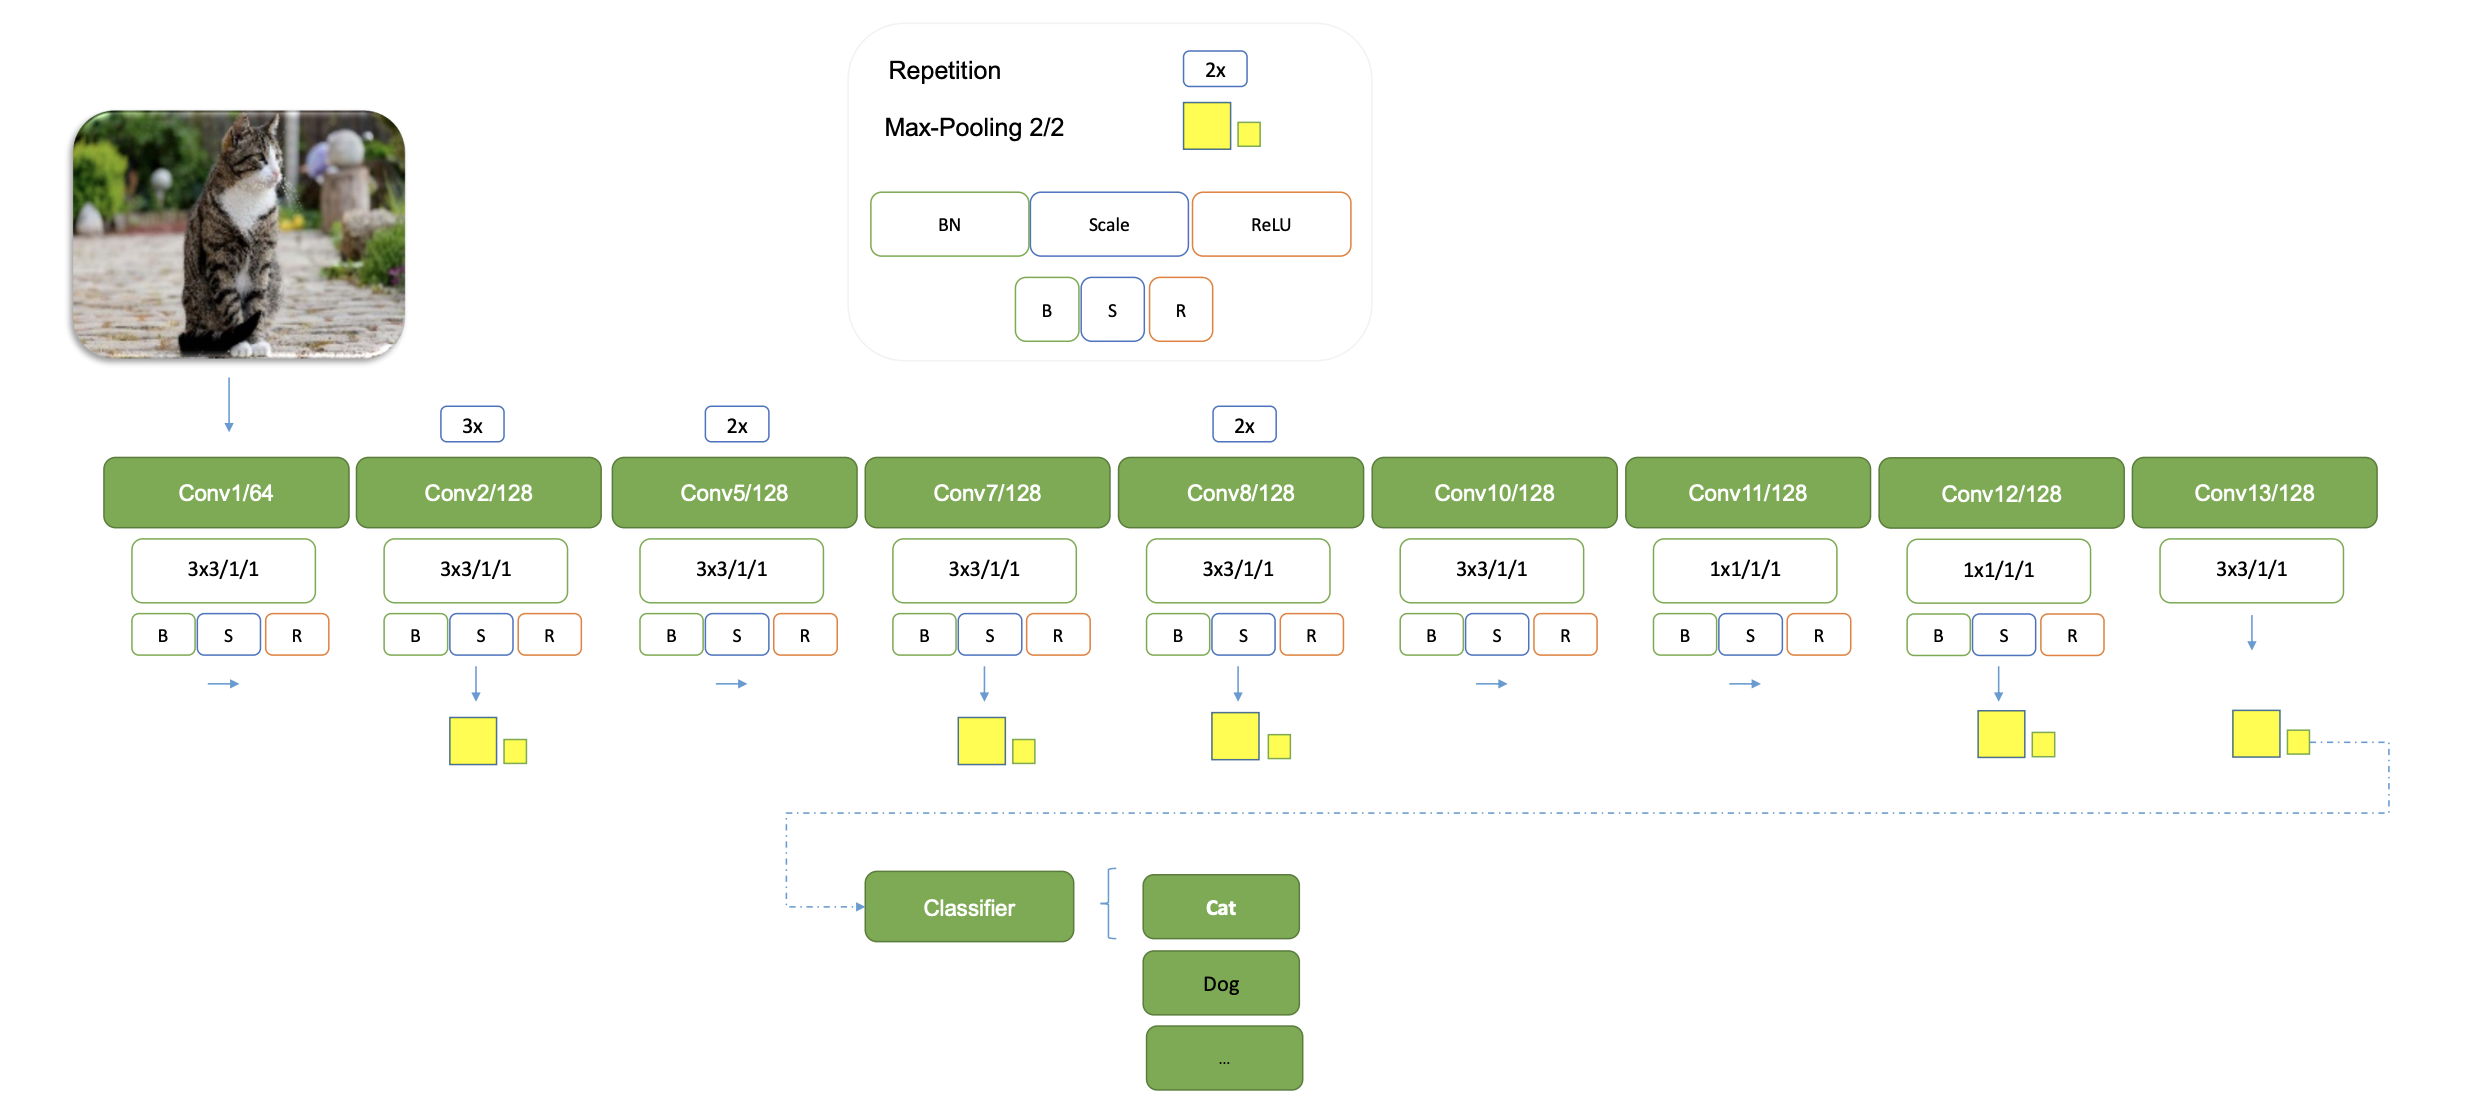

In [1]:
from IPython.display import Image
Image(filename='img/simplenet.png') 

## Walkthrough of SimpleNet
There are just 13 convolutional layers in SimpleNet, the first having 64 filters and all of the rest with 128. Other than layers 11 and 12, which use 1x1 kernels, all convolutional layers use 3x3 kernels. As you can see from the image, the architecture is quite homogenous, with the general pattern of Convolution -> Batch Normalization -> ReLU activation, and some 2x2 Max Pooling layers (followed by 20% Dropout layers) mixed in. My entire model has only about 1.4 million parameters, which is over 1 million fewer than the inferior model in #1 above, and far less than any of the state-of-the-art methods. 

While my implementation is very similar to the original SimpleNet, there are a few key differences that I will point out:
- SimpleNet implements batch normalization before any ReLU activation, but I found better results when including the activation as part of the convolutional layer, before applying batch normalization. 
- I do not need to apply a Scale layer after batch normalization, since Keras does this by default (unlike Caffe, which the authors use).
- I include 20% Dropout layers after the Max Pooling layers. This is something the authors do in a different iteration, just not in the base model pictured above.
- The authors use AdaDelta as their optimization technique, whereas I found better results with Adam.

## Architectural intuitions of SimpleNet
In the paper, the authors of SimpleNet also provide an explanation of the beneficial properties of this architecture. Here is a summary of some of the reasons why SimpleNet is successful:
- **Regularization**: The authors use batch normalization and dropout to prevent overfitting. Batch normalization also helps to deal with the vanishing gradient problem. I also experimented with an L2 weight regularizer on the final dense layer because the model still does overfit to an extent, but it decreased the accuracy.
- **Gradual Expansion and Minimum Allocation**: The authors start with a "small and thin" network and expand outwards in a "symmetric and gradual fashion" until it resembles a cone shape. The intuition for this is that early layers only detect small portions of the input image, whereas later layers come to process progressively larger spatial windows of the image.
- **Homogenous Layer Groups**: All of the convolutional layers are highly similar or identical, making it easier to manage the total number of parameters
- **Local Correlation Preservation**: The authors avoid 1x1 kernels until the end of the network. A smaller receptive field helps to deal with bottleneck at the end of the network, but for earlier layers, a larger field of vision helps to retain valuable information about local correlation among neighboring pixels.
- **Maximum Information Utilization**: The authors use and maintain a fairly large number of filters throughout the network. They also avoid filter down-sampling (i.e. the number of filters never decreases from one layer to the next) in order to provide as much information as possible to the network.

In [26]:
#Hyperparameters
batch_size = 128
learning_rate = 0.001 #Faster learning rates lead to huge fluctuations in validation loss
epochs = 100
metrics = ['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5)]

In [27]:
model = keras.Sequential()
#1) First convolutional layer with batch normalization and ReLU activation
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = (32,32,3)))
model.add(keras.layers.BatchNormalization())
#2) 3x convolutional layers with 128 filters, batch normalization, ReLU activation -> Max Pooling layer + 0.2 Dropout
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
#3) 2x convolutional layers with 128 filters, batch normalization, ReLU activation
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
#4) Convolutional layer with 128 filters, batch normalization, ReLU activation -> Max Pooling layer + 0.2 Dropout
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
#5) 2x convolutional layers with 128 filters, batch normalization, ReLU activation -> Max Pooling layer + 0.2 Dropout
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
#6) Convolutional layer with 128 filters, batch normalization, ReLU activation
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
#7) Convolutional layer with 128 filters, batch normalization, ReLU activation and 1x1 receptive field
model.add(keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
#8) Convolutional layer with 128 filters, batch normalization, ReLU activation and 1x1 receptive field -> Max Pooling layer + 0.2 Dropout
model.add(keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
#9) Convolutional layer with 128 filters, batch normalization, ReLU activation and 3x3 receptive field -> Max Pooling layer + 0.2 Dropout
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
#10) Final Dense layer with Softmax activation
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)      

In [28]:
opt = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
print('\nTraining model...')
history = model.fit(data_train, label_train, batch_size=batch_size, epochs=epochs, shuffle=True,
          validation_data = (data_test, label_test), verbose=1)


Training model...
Epoch 1/100
391/391 [==============================] - 30s 74ms/step - loss: 2.0106 - accuracy: 0.3338 - top_k_categorical_accuracy: 0.8340 - val_loss: 2.4677 - val_accuracy: 0.2611 - val_top_k_categorical_accuracy: 0.7654
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 1.1633 - accuracy: 0.5913 - top_k_categorical_accuracy: 0.9581 - val_loss: 1.0706 - val_accuracy: 0.6598 - val_top_k_categorical_accuracy: 0.9567
Epoch 3/100
391/391 [==============================] - 29s 75ms/step - loss: 0.8067 - accuracy: 0.7190 - top_k_categorical_accuracy: 0.9799 - val_loss: 0.7907 - val_accuracy: 0.7337 - val_top_k_categorical_accuracy: 0.9797
Epoch 4/100
391/391 [==============================] - 29s 75ms/step - loss: 0.6540 - accuracy: 0.7744 - top_k_categorical_accuracy: 0.9868 - val_loss: 0.8585 - val_accuracy: 0.7263 - val_top_k_categorical_accuracy: 0.9774
Epoch 5/100
391/391 [==============================] - 29s 75ms/step - loss: 0.5567 - acc

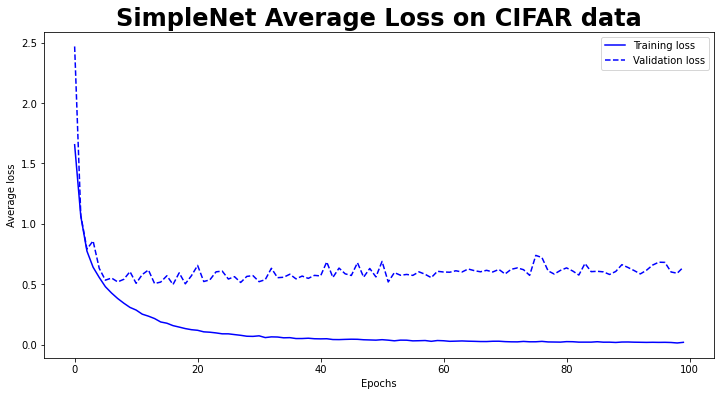

In [30]:
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(history.history['loss'], color='blue', label='Training loss')
axes.plot(history.history['val_loss'], color='blue', linestyle='dashed', label='Validation loss')
axes.set_xlabel('Epochs')
axes.set_ylabel('Average loss')
axes.set_title('SimpleNet Average Loss on CIFAR data', fontsize=24, fontweight='bold')
axes.legend()

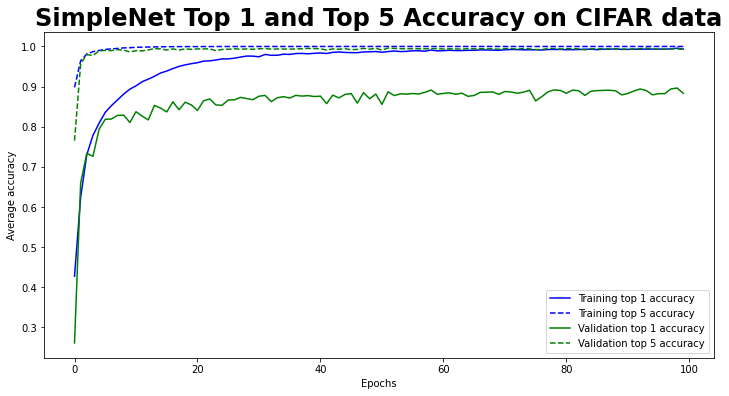

In [31]:
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(history.history['accuracy'], color='blue', label='Training top 1 accuracy')
axes.plot(history.history['top_k_categorical_accuracy'], color='blue', linestyle='dashed', label='Training top 5 accuracy')
axes.plot(history.history['val_accuracy'], color='green', label='Validation top 1 accuracy')
axes.plot(history.history['val_top_k_categorical_accuracy'], color='green', linestyle='dashed', label='Validation top 5 accuracy')
axes.set_xlabel('Epochs')
axes.set_ylabel('Average accuracy')
axes.set_title('SimpleNet Top 1 and Top 5 Accuracy on CIFAR data', fontsize=24, fontweight='bold')
axes.legend()

## Discussion
The validation loss for my SimpleNet implementation levels off within the first 10 epochs, an example of the Adam optimizer being able to learn very quickly. After 100 epochs, SimpleNet has essentially learned the CIFAR 10 data completely, as the training loss is reduced to nearly zero.

In terms of classification accuracy, this version of SimpleNet achieves 88.3% accuracy on the validation data, a fairly impressive result considering its reduced complexity and overhead when compared to the state-of-the-art models. In fact, SimpleNet is able to reach this level of accuracy after only a few dozen epochs, which means that reduced runtime is another potential benefit of this architecture. SimpleNet's Top 5 classification accuracy is nearly 100% within the first 10 epochs and remains there throughout the training period. Given that there are only 10 classes, this is not a difficult threshold. Top 5 accuracy would be more informative given a more complicated input dataset with more classes, more objects in each image, etc.

In terms of future directions, the authors are able to achieve over 95% accuracy on the CIFAR 10 data. For the purposes of this analysis, my SimpleNet certainly achieves reasonable Top 1 and Top 5 accuracy, but it would be interesting to continue playing with this architecture to push the accuracy above 90%. One potential addition would be data augmentation, which the authors use in order to achieve slightly better performance over their baseline (95.3% vs 94.8%). Ultimately, having such a lightweight model could prove useful for future computer vision tasks involving more complex data.